In [1]:
import cupy as cp
from cupyx.scipy.spatial import distance as cupy_distance

In [2]:
import cudf
import cupy as cp
import geopandas as gpd
import pandas as pd 
import cuspatial
import cupy as cp
from cupyx.scipy.spatial import distance as cupy_distance
gpkg_path = r"finished_data.gpkg"
try:
    gdf_host = gpd.read_file(gpkg_path, engine='pyogrio', use_arrow = True)

except Exception as e:
    print(f"Error reading GeoPackage: {e}")

lsoa_path = "/mnt/c/Users/Ruben/Documents/project_crime/data/main/processed_london_crime_data.gpkg"
lsao_gdf =  gpd.read_file(lsoa_path, engine='pyogrio', layer="LSOA", use_arrow = True)


In [3]:
msoa_path = "/mnt/c/Users/Ruben/Documents/project_crime/data/main/processed_london_crime_data.gpkg"
msao_gdf =  gpd.read_file(lsoa_path, engine='pyogrio', layer="MSOA", use_arrow = True)

In [ ]:
#gdf_filtered = gdf_host[(gdf_host['year'] > 2010) & (gdf_host['year'] < 2013)].copy()

In [5]:
gdf_filtered

,lsoa_code,year,month,log_crime_count,mean_temperature,max_mean_temperature,percent_youth,population_density,ethnic_diversity_index_11,inf_change_1month,...,Vacation_Days,unemployment_unadj,median_age,per_unemployment_lsoa_2011,per_social_grade_DE,parks_count_within,bars_pubs_count_within,sports_count_within,pct_park_area_within,geometry
0,E01000001,2011.0,1.0,1.098612e+00,7.755641,11.144518,5.774457,11340.523883,0.120195,0.1,...,0,7.7,45.0,0.027846,0.017725,0.0,0.0,0.0,0.000000,"MULTIPOLYGON (((532105.092 182011.23, 532162.4..."
1,E01000001,2011.0,2.0,6.931472e-01,10.725174,15.652281,5.774457,11340.523883,0.120195,0.6,...,7,7.8,45.0,0.027846,0.017725,0.0,0.0,0.0,0.000000,"MULTIPOLYGON (((532105.092 182011.23, 532162.4..."
2,E01000001,2011.0,3.0,-1.842068e+01,12.543472,17.205110,5.774457,11340.523883,0.120195,0.3,...,0,7.6,45.0,0.027846,0.017725,0.0,0.0,0.0,0.000000,"MULTIPOLYGON (((532105.092 182011.23, 532162.4..."
3,E01000001,2011.0,4.0,6.931472e-01,17.445540,22.805479,5.774457,11340.523883,0.120195,0.8,...,14,7.6,45.0,0.027846,0.017725,0.0,0.0,0.0,0.000000,"MULTIPOLYGON (((532105.092 182011.23, 532162.4..."
4,E01000001,2011.0,5.0,1.386294e+00,20.090016,24.754853,5.774457,11340.523883,0.120195,0.2,...,0,7.8,45.0,0.027846,0.017725,0.0,0.0,0.0,0.000000,"MULTIPOLYGON (((532105.092 182011.23, 532162.4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580099,E01033746,2012.0,8.0,1.386294e+00,14.128007,18.034036,6.391753,11456.692913,0.132867,0.4,...,31,8.1,37.0,0.031001,0.102273,24.0,1.0,1.0,2.104264,"MULTIPOLYGON (((538140 177313, 538129.177 1772..."
580100,E01033746,2012.0,9.0,1.945910e+00,10.886137,13.854290,6.391753,11456.692913,0.132867,0.4,...,7,8.1,37.0,0.031001,0.102273,24.0,1.0,1.0,2.104264,"MULTIPOLYGON (((538140 177313, 538129.177 1772..."
580101,E01033746,2012.0,10.0,1.098612e+00,7.106073,10.013601,6.391753,11456.692913,0.132867,0.4,...,7,7.9,37.0,0.031001,0.102273,24.0,1.0,1.0,2.104264,"MULTIPOLYGON (((538140 177313, 538129.177 1772..."
580102,E01033746,2012.0,11.0,1.000000e-08,6.910820,10.032263,6.391753,11456.692913,0.132867,0.1,...,0,7.7,37.0,0.031001,0.102273,24.0,1.0,1.0,2.104264,"MULTIPOLYGON (((538140 177313, 538129.177 1772..."


In [6]:
gdf_filtered = gdf_filtered.merge(
    lsao_gdf[['LSOA11CD', 'MSOA11CD']],
    left_on='lsoa_code',
    right_on='LSOA11CD',
    how='left'
).drop(columns=['LSOA11CD'])

In [7]:
gdf_filtered = gdf_filtered.merge(
    msao_gdf[['MSOA11CD', 'geometry']],
    left_on='MSOA11CD',
    right_on='MSOA11CD',
    how='left'
).drop('geometry_x', axis=1).rename(columns={'geometry_y': 'geometry'})
gdf_filtered.geometry = gdf_filtered['geometry']

In [8]:
def check_doubles(gdf, lsoa_code_column):
    code_to_geom_counts = gdf.groupby(lsoa_code_column)['geometry'].nunique()
    codes_with_multiple_geoms = code_to_geom_counts[code_to_geom_counts > 1]

    if codes_with_multiple_geoms.empty:
        print("Result: PASSED. Each LSOA code maps to exactly one unique geometry.")
    else:
        print(f"Result: FAILED. Found {len(codes_with_multiple_geoms)} LSOA codes mapping to multiple geometries:")
        print(codes_with_multiple_geoms)

    geom_to_code_counts = gdf.groupby('geometry')[lsoa_code_column].nunique()
    geoms_with_multiple_codes = geom_to_code_counts[geom_to_code_counts > 1]

    if geoms_with_multiple_codes.empty:
        print("Result: PASSED. Each unique geometry maps to exactly one LSOA code.")
    else:
        print(f"Result: FAILED. Found {len(geoms_with_multiple_codes)} unique geometries mapping to multiple LSOA codes.")
        # Printing the geometries themselves might be too verbose, let's show the count
        print(f"Example issue counts per geometry (WKT truncated):")
        # Display a few examples if there are many
        display_limit = 10
        for wkt, count in geoms_with_multiple_codes.head(display_limit).items():
                print(f"  Geometry (starts with {wkt[:50]}...): associated with {count} LSOA codes")
        if len(geoms_with_multiple_codes) > display_limit:
            print(f"  ... and {len(geoms_with_multiple_codes) - display_limit} more.")
check_doubles(gdf_filtered, 'MSOA11CD')

Result: PASSED. Each LSOA code maps to exactly one unique geometry.
Result: PASSED. Each unique geometry maps to exactly one LSOA code.


In [9]:
gdf_filtered.columns

Index(['lsoa_code', 'year', 'month', 'log_crime_count', 'mean_temperature',
       'max_mean_temperature', 'percent_youth', 'population_density',
       'ethnic_diversity_index_11', 'inf_change_1month', 'inf_base2015',
       'Avg_Daylight_Hours', 'Vacation_Days', 'unemployment_unadj',
       'median_age', 'per_unemployment_lsoa_2011', 'per_social_grade_DE',
       'parks_count_within', 'bars_pubs_count_within', 'sports_count_within',
       'pct_park_area_within', 'MSOA11CD', 'geometry'],
      dtype='object')

<Axes: >

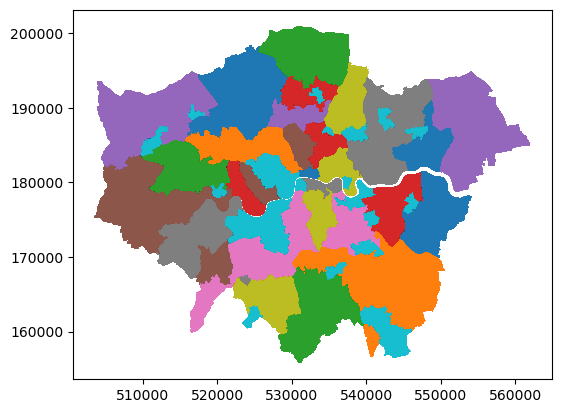

In [10]:
gdf_filtered.plot(column = "MSOA11CD")

In [12]:
gdf_filtered.head()

,lsoa_code,year,month,log_crime_count,mean_temperature,max_mean_temperature,percent_youth,population_density,ethnic_diversity_index_11,inf_change_1month,...,unemployment_unadj,median_age,per_unemployment_lsoa_2011,per_social_grade_DE,parks_count_within,bars_pubs_count_within,sports_count_within,pct_park_area_within,MSOA11CD,geometry
0,E01000001,2011.0,1.0,1.098612,7.755641,11.144518,5.774457,11340.523883,0.120195,0.1,...,7.7,45.0,0.027846,0.017725,0.0,0.0,0.0,0.0,E02000001,"MULTIPOLYGON (((531667.624 180534.992, 531647...."
1,E01000001,2011.0,2.0,0.693147,10.725174,15.652281,5.774457,11340.523883,0.120195,0.6,...,7.8,45.0,0.027846,0.017725,0.0,0.0,0.0,0.0,E02000001,"MULTIPOLYGON (((531667.624 180534.992, 531647...."
2,E01000001,2011.0,3.0,-18.420681,12.543472,17.205110,5.774457,11340.523883,0.120195,0.3,...,7.6,45.0,0.027846,0.017725,0.0,0.0,0.0,0.0,E02000001,"MULTIPOLYGON (((531667.624 180534.992, 531647...."
3,E01000001,2011.0,4.0,0.693147,17.445540,22.805479,5.774457,11340.523883,0.120195,0.8,...,7.6,45.0,0.027846,0.017725,0.0,0.0,0.0,0.0,E02000001,"MULTIPOLYGON (((531667.624 180534.992, 531647...."
4,E01000001,2011.0,5.0,1.386294,20.090016,24.754853,5.774457,11340.523883,0.120195,0.2,...,7.8,45.0,0.027846,0.017725,0.0,0.0,0.0,0.0,E02000001,"MULTIPOLYGON (((531667.624 180534.992, 531647...."


In [13]:
import geopandas as gpd
import pandas as pd

# Assume 'gdf_filtered' is your prepared GeoPandas DataFrame
# Ensure it contains 'year_month', 'MSOA11CD', and all columns listed below.
print("Original DataFrame info:")
gdf_filtered.info()
print(f"Original shape: {gdf_filtered.shape}")

# Define the aggregation rules 
aggregation_rules = {
    # --- Columns to average ---
    'log_crime_count': 'mean',
    'mean_temperature': 'mean',
    'max_mean_temperature': 'max',
    'percent_youth': 'mean',
    'population_density': 'mean',      
    'ethnic_diversity_index_11': 'mean',
    'inf_change_1month': 'mean',
    'inf_base2015': 'mean',
    'Avg_Daylight_Hours': 'mean',
    'Vacation_Days': 'mean',         
    'unemployment_unadj': 'mean',
    'median_age': 'mean',
    'per_unemployment_lsoa_2011': 'mean',
    'per_social_grade_DE': 'mean',
    'pct_park_area_within': 'mean',    #

    # --- Columns to sum ("count" values) ---
    'parks_count_within': 'sum',
    'bars_pubs_count_within': 'sum',
    'sports_count_within': 'sum',

    # --- Columns where we take the first value (representative) ---
    'geometry': 'first',            #geometry is consistent per MSOA within the group


}

# Coerce to numeric, turn invalid strings into NaN
for col, rule in aggregation_rules.items():
    if rule in ['mean', 'max' 'sum'] and col in gdf_filtered.columns:
        gdf_filtered[col] = pd.to_numeric(gdf_filtered[col], errors='coerce')


# Check which columns from rules actually exist in the dataframe
cols_to_agg = {col: rule for col, rule in aggregation_rules.items() if col in gdf_filtered.columns}


gdf_aggregated_pd = gdf_filtered.groupby(['year', 'month', 'MSOA11CD'], observed=True, sort=False).agg(cols_to_agg)
gdf_aggregated_pd = gdf_aggregated_pd.reset_index()

# Convert back to a GeoDataFrame, preserving the CRS
if 'geometry' in gdf_aggregated_pd.columns:
    original_crs = gdf_filtered.crs
    gdf_aggregated = gpd.GeoDataFrame(
        gdf_aggregated_pd,
        geometry='geometry',
        crs=original_crs
    )
    print("Aggregation complete. Result is a GeoDataFrame.")
else:
    gdf_aggregated = gdf_aggregated_pd # Result is a regular DataFrame if geometry wasn't aggregated
    print("Aggregation complete. Result is a DataFrame (no geometry column found/aggregated).")


# --- Verification ---
print(f"\nShape of aggregated DataFrame: {gdf_aggregated.shape}")
print("\nColumns in aggregated DataFrame:", gdf_aggregated.columns)
print("\nHead of aggregated DataFrame:")
print(gdf_aggregated.head())
print("\nInfo of aggregated DataFrame:")
gdf_aggregated.info()


Original DataFrame info:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 116040 entries, 0 to 116039
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   lsoa_code                   116040 non-null  object  
 1   year                        116040 non-null  float64 
 2   month                       116040 non-null  float64 
 3   log_crime_count             116040 non-null  float64 
 4   mean_temperature            116040 non-null  float64 
 5   max_mean_temperature        116040 non-null  float64 
 6   percent_youth               116040 non-null  float64 
 7   population_density          116040 non-null  float64 
 8   ethnic_diversity_index_11   116040 non-null  float64 
 9   inf_change_1month           116040 non-null  object  
 10  inf_base2015                116040 non-null  float64 
 11  Avg_Daylight_Hours          116040 non-null  float64 
 12  Vacation_Days            

In [16]:
len(gdf_aggregated)/24 == len(msao_gdf)

True

In [17]:
x = gdf_aggregated.geometry.centroid.x.astype('float32')
y = gdf_aggregated.geometry.centroid.y.astype('float32')


In [18]:
x_cp = cp.asarray(x.to_numpy())
y_cp = cp.asarray(y.to_numpy())

# Stack the CuPy arrays
coords_cp = cp.stack([x_cp, y_cp], axis=1)


In [19]:
len(coords_cp)

23592

In [20]:
coords_cp

array([[532482.7 , 181269.31],
       [532482.7 , 181269.31],
       [532482.7 , 181269.31],
       ...,
       [525456.  , 181816.8 ],
       [525456.  , 181816.8 ],
       [525456.  , 181816.8 ]], dtype=float32)

In [ ]:
gdf_aggregated.columns

Index(['lsoa_code', 'year', 'month', 'log_crime_count', 'mean_temperature',
       'max_mean_temperature', 'percent_youth', 'population_density',
       'ethnic_diversity_index_11', 'inf_change_1month', 'inf_base2015',
       'Avg_Daylight_Hours', 'Vacation_Days', 'unemployment_unadj',
       'median_age', 'per_unemployment_lsoa_2011', 'per_social_grade_DE',
       'parks_count_within', 'bars_pubs_count_within', 'sports_count_within',
       'pct_park_area_within', 'MSOA11CD', 'geometry'],
      dtype='object')

In [23]:
gdf_aggregated['year_month'] = gdf_aggregated['year'].astype(int).astype(str) + '-' + gdf_aggregated['month'].astype(int).apply(lambda m: f"{m:02d}").astype(str)
gdf_aggregated

,year,month,MSOA11CD,log_crime_count,mean_temperature,max_mean_temperature,percent_youth,population_density,ethnic_diversity_index_11,inf_change_1month,...,unemployment_unadj,median_age,per_unemployment_lsoa_2011,per_social_grade_DE,pct_park_area_within,parks_count_within,bars_pubs_count_within,sports_count_within,geometry,year_month
0,2011.0,1.0,E02000001,2.167792,7.765419,11.231407,10.558820,8005.642296,0.147735,0.1,...,7.7,38.416667,0.031265,0.074825,0.701030,3.0,1.0,0.0,"MULTIPOLYGON (((531667.624 180534.992, 531647....",2011-01
1,2011.0,2.0,E02000001,2.394927,10.742520,15.738690,10.558820,8005.642296,0.147735,0.6,...,7.8,38.416667,0.031265,0.074825,0.701030,3.0,1.0,0.0,"MULTIPOLYGON (((531667.624 180534.992, 531647....",2011-02
2,2011.0,3.0,E02000001,-0.830886,12.561522,17.263120,10.558820,8005.642296,0.147735,0.3,...,7.6,38.416667,0.031265,0.074825,0.701030,3.0,1.0,0.0,"MULTIPOLYGON (((531667.624 180534.992, 531647....",2011-03
3,2011.0,4.0,E02000001,2.423959,17.467576,22.855778,10.558820,8005.642296,0.147735,0.8,...,7.6,38.416667,0.031265,0.074825,0.701030,3.0,1.0,0.0,"MULTIPOLYGON (((531667.624 180534.992, 531647....",2011-04
4,2011.0,5.0,E02000001,2.284803,20.105826,24.834827,10.558820,8005.642296,0.147735,0.2,...,7.8,38.416667,0.031265,0.074825,0.701030,3.0,1.0,0.0,"MULTIPOLYGON (((531667.624 180534.992, 531647....",2011-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23587,2012.0,8.0,E02000969,-2.169636,14.093648,17.947205,12.867286,18635.950320,0.286361,0.4,...,8.1,32.400000,0.069114,0.398031,10.227592,24.0,5.0,8.0,"MULTIPOLYGON (((525340.207 182026.353, 525360....",2012-08
23588,2012.0,9.0,E02000969,1.964564,10.719977,13.670312,12.867286,18635.950320,0.286361,0.4,...,8.1,32.400000,0.069114,0.398031,10.227592,24.0,5.0,8.0,"MULTIPOLYGON (((525340.207 182026.353, 525360....",2012-09
23589,2012.0,10.0,E02000969,-2.238168,6.980548,9.894207,12.867286,18635.950320,0.286361,0.4,...,7.9,32.400000,0.069114,0.398031,10.227592,24.0,5.0,8.0,"MULTIPOLYGON (((525340.207 182026.353, 525360....",2012-10
23590,2012.0,11.0,E02000969,-2.520714,6.851062,9.800559,12.867286,18635.950320,0.286361,0.1,...,7.7,32.400000,0.069114,0.398031,10.227592,24.0,5.0,8.0,"MULTIPOLYGON (((525340.207 182026.353, 525360....",2012-11


In [24]:
gdf_aggregated['time_var'] = (gdf_aggregated['year_month'].astype('category').cat.codes + 1).astype('int8')

In [25]:
gdf_aggregated['time_var'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24], dtype=int8)

In [41]:
gdf_aggregated.to_file("MSOA_processed_data.gpkg", driver="GPKG", layer="MSOA", index=False)

In [35]:
s_dMat_cp = cupy_distance.cdist(coords_cp, coords_cp, metric='euclidean')

In [39]:
epsilon = 1e-5
s_dMat_cp = cp.where(s_dMat_cp == 0, epsilon, s_dMat_cp)

In [40]:
s_dMat_cp

array([[9.9999997e-06, 9.9999997e-06, 9.9999997e-06, ..., 7.0527886e+03,
        7.0527886e+03, 7.0527886e+03],
       [9.9999997e-06, 9.9999997e-06, 9.9999997e-06, ..., 7.0527886e+03,
        7.0527886e+03, 7.0527886e+03],
       [9.9999997e-06, 9.9999997e-06, 9.9999997e-06, ..., 7.0527886e+03,
        7.0527886e+03, 7.0527886e+03],
       ...,
       [7.0527886e+03, 7.0527886e+03, 7.0527886e+03, ..., 2.5600000e+02,
        2.5600000e+02, 2.5600000e+02],
       [7.0527886e+03, 7.0527886e+03, 7.0527886e+03, ..., 2.5600000e+02,
        2.5600000e+02, 2.5600000e+02],
       [7.0527886e+03, 7.0527886e+03, 7.0527886e+03, ..., 2.5600000e+02,
        2.5600000e+02, 2.5600000e+02]], dtype=float32)

In [ ]:
time_cp = cp.asarray(gdf_aggregated['time_var'].to_numpy())
print(f"\nCreated time_cp CuPy array with shape: {time_cp.shape} and dtype: {time_cp.dtype}")



Created time_cp CuPy array with shape: (23592,) and dtype: int8


In [ ]:
import cupy as cp
from cupyx.scipy.spatial import distance as cupy_distance
import math
import time # To time the process



N = coords_cp.shape[0]
print(f"Total number of points (N): {N}")

# --- Configuration ---
# Adjust chunk_size based on your GPU memory.
# Calculation: chunk_size * N * 8 bytes (for float64) should fit comfortably.
# E.g., for 32GB GPU memory (~30GB usable for allocation):
# chunk_size <= (30 * 1024**3) / (N * 8)
# chunk_size <= 32,212,254,720 / (580200 * 8) ~ 6940
# Let's choose a slightly smaller, safer value.
chunk_size = (20 * 1024**3) / (N * 4)
num_chunks = math.ceil(N / chunk_size)
print(f"Using chunk_size: {chunk_size} ({num_chunks} chunks total)")

# --- Placeholders / Accumulators (IF NEEDED) ---
# You CANNOT store the full matrix. You need to decide how to process each chunk.
# Example: If you only needed the minimum distance for each point in the chunk:
# min_distances_all = cp.zeros(N, dtype=cp.float64)
# Example: If saving chunks to disk (requires ~2.5 TB disk space!)
# output_dir = "./distance_chunks"
# import os
# os.makedirs(output_dir, exist_ok=True)
# -------------------------------------------------

start_time_total = time.time()

# Loop through the rows in chunks
for i in range(num_chunks):
    start_row = i * chunk_size
    end_row = min((i + 1) * chunk_size, N)
    current_chunk_size = end_row - start_row

    print(f"\nProcessing chunk {i+1}/{num_chunks} (rows {start_row} to {end_row})...")
    start_time_chunk = time.time()

    # Get the current chunk of coordinates
    chunk_coords = coords_cp[start_row:end_row]

    # --- Calculate Spatial Distance Chunk ---
    # s_dist_chunk shape: (current_chunk_size, N)
    s_dist_chunk = cupy_distance.cdist(chunk_coords, coords_cp, metric='euclidean')
    print(f"  Calculated spatial distance chunk with shape: {s_dist_chunk.shape}")

    # --- OPTIONAL: Calculate Temporal & Spatio-Temporal Distance Chunk ---
    # Uncomment and adapt if you need the ST distance
    lambda_val = 0.05
    p_val = 2
    chunk_time = time_cp[start_row:end_row]
    t_dist_chunk = cp.abs(chunk_time[:, None] - time_cp[None, :])
    st_dist_chunk = cp.sqrt(cp.power(s_dist_chunk, p_val) + cp.power(lambda_val * t_dist_chunk, p_val))
    # print(f"  Calculated ST distance chunk with shape: {st_dist_chunk.shape}")
    # -------------------------------------------------------------------


    # --- !!! CRUCIAL STEP: PROCESS OR SAVE THE CHUNK(S) HERE !!! ---
    # You cannot hold all chunks in memory. Process them immediately.

    # Example 1: Find and store minimum distance for points in this chunk
    min_dists_chunk = cp.min(s_dist_chunk, axis=1) # Find min distance to any other point
    min_distances_all[start_row:end_row] = min_dists_chunk
    # print(f"  Processed chunk (found min distances).")

    # Example 2: Save the spatial distance chunk to disk (HIGH DISK USAGE!)
    chunk_filename = os.path.join(output_dir, f"s_dist_chunk_{i:04d}.npy")
    cp.save(chunk_filename, s_dist_chunk)
    print(f"  Saved chunk to {chunk_filename}")

    # Example 3: Pass the chunk to your custom downstream function
    # your_custom_function(s_dist_chunk, start_row, end_row) # Pass st_dist_chunk if needed
    # print(f"  Passed chunk to custom processing function.")

    # --- IMPORTANT: Placeholder - replace with your actual processing ---
    print(f"  TODO: Implement actual processing/saving for the calculated chunk(s) here.")
    pass # Replace 'pass' with your processing logic


    # --- Cleanup GPU memory (good practice) ---
    del chunk_coords, s_dist_chunk
    # if 't_dist_chunk' in locals(): del t_dist_chunk
    # if 'st_dist_chunk' in locals(): del st_dist_chunk
    # if 'chunk_time' in locals(): del chunk_time
    cp.get_default_memory_pool().free_all_blocks() # Clear memory pool cache
    # ---------------------------------------------

    end_time_chunk = time.time()
    print(f"  Chunk {i+1} finished in {end_time_chunk - start_time_chunk:.2f} seconds.")
    # Optional: Check available memory
    # mem_info = cp.cuda.Device().mem_info
    # print(f"  GPU Memory Free: {mem_info[0]/1024**3:.2f} GB / Total: {mem_info[1]/1024**3:.2f} GB")


end_time_total = time.time()
print(f"\nFinished processing all chunks in {end_time_total - start_time_total:.2f} seconds.")

# --- Final Result ---
# The final result is not stored in a single matrix 's_dMat_cp'.
# Instead, the results have been processed/saved chunk-by-chunk within the loop.
# Example: If accumulating min distances:
# print("Final minimum distances (first 10):", min_distances_all[:10])
# --------------------

In [15]:
cugpdf = cuspatial.GeoDataFrame(gdf_host)

In [22]:
points_x = gdf_host.geometry.centroid.x.astype('float64')
points_y = gdf_host.geometry.centroid.y.astype('float64')

In [23]:
points_x

0         532150.879391
1         532150.879391
2         532150.879391
3         532150.879391
4         532150.879391
              ...      
580195    538054.131164
580196    538054.131164
580197    538054.131164
580198    538054.131164
580199    538054.131164
Length: 580200, dtype: float64

In [12]:
cugpdf.rename(columns={'log_crime_count': 'crime_count'}, inplace=True)

TypeError: Cannot interpret geometry as a valid cuDF dtype

TypeError: Cannot interpret geometry as a valid cuDF dtype

        lsoa_code    year  month  crime_count  mean_temperature  \
0       E01000001  2011.0    1.0     1.098612          7.755641   
1       E01000001  2011.0    2.0     0.693147         10.725174   
2       E01000001  2011.0    3.0   -18.420681         12.543472   
3       E01000001  2011.0    4.0     0.693147         17.445540   
4       E01000001  2011.0    5.0     1.386294         20.090016   
...           ...     ...    ...          ...               ...   
580195  E01033746  2019.0    8.0     1.098612         12.491128   
580196  E01033746  2019.0    9.0     1.791759          9.342204   
580197  E01033746  2019.0   10.0     0.693147          8.065854   
580198  E01033746  2019.0   11.0     1.386294          4.874487   
580199  E01033746  2019.0   12.0     1.098612          7.759779   

        max_mean_temperature  percent_youth  population_density  \
0                  11.144518       5.774457        11340.523883   
1                  15.652281       5.774457        11340.5238

In [6]:
geom_col = gdf_filtered.geometry.name
geom_col

'geometry'

In [8]:
gdf_filtered['x'] = gdf_filtered[geom_col].x
gdf_filtered['y'] = gdf_filtered[geom_col].y

ValueError: x attribute access only provided for Point geometries

In [ ]:

# --- 4. Extract Coordinates (Requires geometry column) ---
# Find the geometry column (often 'geometry' or 'geom')
geom_col = gdf_filtered.geometry.name
print(f"Using geometry column: {geom_col}")

if geom_col not in gdf_filtered.columns:
     print("Error: Geometry column not found.")
     # Handle error: maybe exit or assign NaN coordinates
     gdf_filtered['x_coord'] = cp.nan
     gdf_filtered['y_coord'] = cp.nan
else:
     # IMPORTANT: Check Coordinate Reference System (CRS).
     # For distance calculations later, you'll want projected coordinates (like BNG: EPSG:27700)
     # not geographic coordinates (like WGS84: EPSG:4326).
     print(f"Original CRS: {gdf_filtered.crs}")
     # Example: If CRS is WGS84, uncomment the next line to project to BNG
     # if gdf_filtered.crs.to_epsg() == 4326:
     #     print("Projecting coordinates to EPSG:27700 (British National Grid)")
     #     gdf_filtered = gdf_filtered.to_crs('EPSG:27700')

     # Extract coordinates AFTER potential projection
     gdf_filtered['x_coord'] = gdf_filtered[geom_col].x
     gdf_filtered['y_coord'] = gdf_filtered[geom_col].y
     print("Extracted 'x_coord' and 'y_coord'")


# --- 5. Create 'year_month' string and numeric 'time_var' ---
# Ensure month is zero-padded for correct sorting (e.g., '2011-01')
gdf_filtered['year_str'] = gdf_filtered['year'].astype(str)
gdf_filtered['month_str'] = gdf_filtered['month'].astype(str).str.zfill(2)
gdf_filtered['year_month'] = gdf_filtered['year_str'] + '-' + gdf_filtered['month_str']

# Sort by time (and location for consistency) is crucial for factorize
gdf_filtered.sort_values(by=['year_month', 'lsoa_code'], inplace=True)
print("Created and sorted by 'year_month'")

# Create a sequential integer 'time_var' (0, 1, 2, ...)
# Using pandas.factorize before converting to cuDF is often easiest
gdf_filtered['time_var'], unique_times = pd.factorize(gdf_filtered['year_month'], sort=True)
print("Created 'time_var'")
# print("Unique times mapping:", dict(enumerate(unique_times))) # Optional


# --- 6. Select Columns and Convert relevant part to cuDF ---
# Define the columns you need for the GTWR analysis
# Ensure these names match the columns *after* filtering and renaming
columns_for_cudf = [
    "lsoa_code", "year", "month", "crime_count", "mean_temperature",
    "max_mean_temperature", "percent_youth", "population_density",
    "ethnic_diversity_index_11", "inf_change_1month", "inf_base2015",
    "Avg_Daylight_Hours", "Vacation_Days", "unemployment_unadj", "median_age",
    "per_unemployment_lsoa_2011", "per_social_grade_DE", "parks_count_within",
    "bars_pubs_count_within", "sports_count_within", "pct_park_area_within",
    "x_coord", "y_coord", # Use the extracted coordinates
    "time_var"           # Use the created numeric time index
]

# Select only the necessary columns from the pandas/geopandas DataFrame
# Check which columns are actually available to avoid errors
available_cols_final = [col for col in columns_for_cudf if col in gdf_filtered.columns]
missing_cols_final = [col for col in columns_for_cudf if col not in gdf_filtered.columns]
if missing_cols_final:
    print(f"Warning: Final selection missing expected columns: {missing_cols_final}")

pdf_subset = gdf_filtered[available_cols_final]

# Convert the pandas DataFrame subset to a cuDF DataFrame
cudf_data = cudf.from_pandas(pdf_subset)
print(f"Converted data to cuDF DataFrame. Shape: {cudf_data.shape}")

# Clean up large intermediate CPU object if needed
# import gc
# del gdf, gdf_filtered, pdf_subset
# gc.collect()


# --- 7. Ensure Correct Data Types in cuDF ---
# Define expected numeric types (use float32 for GPU efficiency if precision allows)
numeric_cols_cudf = [
    "crime_count", "mean_temperature", "max_mean_temperature", "percent_youth",
    "population_density", "ethnic_diversity_index_11", "inf_change_1month",
    "inf_base2015", "Avg_Daylight_Hours", "Vacation_Days", "unemployment_unadj",
    "median_age", "per_unemployment_lsoa_2011", "per_social_grade_DE",
    "parks_count_within", "bars_pubs_count_within", "sports_count_within",
    "pct_park_area_within", "x_coord", "y_coord"
]
for col in numeric_cols_cudf:
    if col in cudf_data.columns:
        # Check if conversion is needed
        if not pd.api.types.is_numeric_dtype(cudf_data[col].dtype):
             print(f"Converting column '{col}' to float32")
             cudf_data[col] = cudf_data[col].astype('float32')
        elif cudf_data[col].dtype == 'float64': # Optional: convert float64 to float32
             print(f"Converting column '{col}' from float64 to float32")
             cudf_data[col] = cudf_data[col].astype('float32')


# Define expected integer types
integer_cols_cudf = ["year", "month", "time_var"]
for col in integer_cols_cudf:
     if col in cudf_data.columns:
          if not pd.api.types.is_integer_dtype(cudf_data[col].dtype):
               print(f"Converting column '{col}' to int32")
               cudf_data[col] = cudf_data[col].astype('int32')

# `lsoa_code` can remain string ('object') or be converted to category
# cudf_data['lsoa_code'] = cudf_data['lsoa_code'].astype('category')
print("Verified/Adjusted cuDF data types.")


# --- Display Results ---
print("\n--- cuDF DataFrame Head ---")
print(cudf_data.head())
print("\n--- cuDF Data Types ---")
print(cudf_data.dtypes)

# ==============================================================
# Next Steps for GTWR (Require Separate GPU Implementations):
# ==============================================================
# 1. Calculate Spatial Distance Matrix (GPU):
#    - Use cudf_data['x_coord'], cudf_data['y_coord']
#    - Libraries: cuML (knn, distance functions), cuPy, Numba (custom kernels)
#    - Example using cuML pairwise_distances (if Euclidean is okay):
#      from cuml.metrics import pairwise_distances
#      coords = cudf_data[['x_coord', 'y_coord']].values # Get as cupy array
#      s_dmat_gpu = pairwise_distances(coords, metric='euclidean')
#      # Note: This creates the full (N*T)x(N*T) matrix on GPU

# 2. Calculate Temporal Distance Matrix (GPU):
#    - Use cudf_data['time_var']
#    - Can often be done efficiently with broadcasting in cuPy
#    - Example:
#      time_vec = cudf_data['time_var'].values # cupy array
#      t_dmat_gpu = cp.abs(time_vec[:, None] - time_vec[None, :])

# 3. Calculate Spatio-Temporal Distance Matrix (GPU):
#    - Combine s_dmat_gpu and t_dmat_gpu using lambda (e.g., lamda * s_dmat + (1-lamda) * t_dmat)
#    - st_dmat_gpu = lamda * s_dmat_gpu + (1 - lamda) * t_dmat_gpu

# 4. Implement GTWR Algorithm (Bandwidth Selection & Fitting) on GPU:
#    - This is the most complex part.
#    - Requires implementing the weighting kernel (e.g., bisquare, gaussian) on GPU.
#    - Requires implementing the weighted least squares solver on GPU (cuML has LinearRegression but needs adaptation for weighted & iterated versions).
#    - Bandwidth selection (AIC/CV) requires iterating this process.
#    - Currently, no standard library provides a direct `gtwr` function on GPU.
# ==============================================================